# Answering_Business_Questions_using_SQL

In this project, we answered business questions using SQL and visualizations. We worked on the Chinook database which is provided as a SQLite database file called `chinook.db` available [here](https://github.com/syed0019/Answering_Business_Questions_using_SQL/blob/master/chinook.db). The [**Chinook**](https://github.com/lerocha/chinook-database) database contains information about a fictional digital music shop - kind of like a mini-iTunes store.

The Chinook database contains information about the artists, songs, and albums from the music shop, as well as information on the shop's employees, customers, and the customers purchases. This information is contained in eleven tables. Below is a schema diagram for the Chinook database that will help us understand the available columns and the structure of the data:

<img src="chinook_schema_diagram.png">
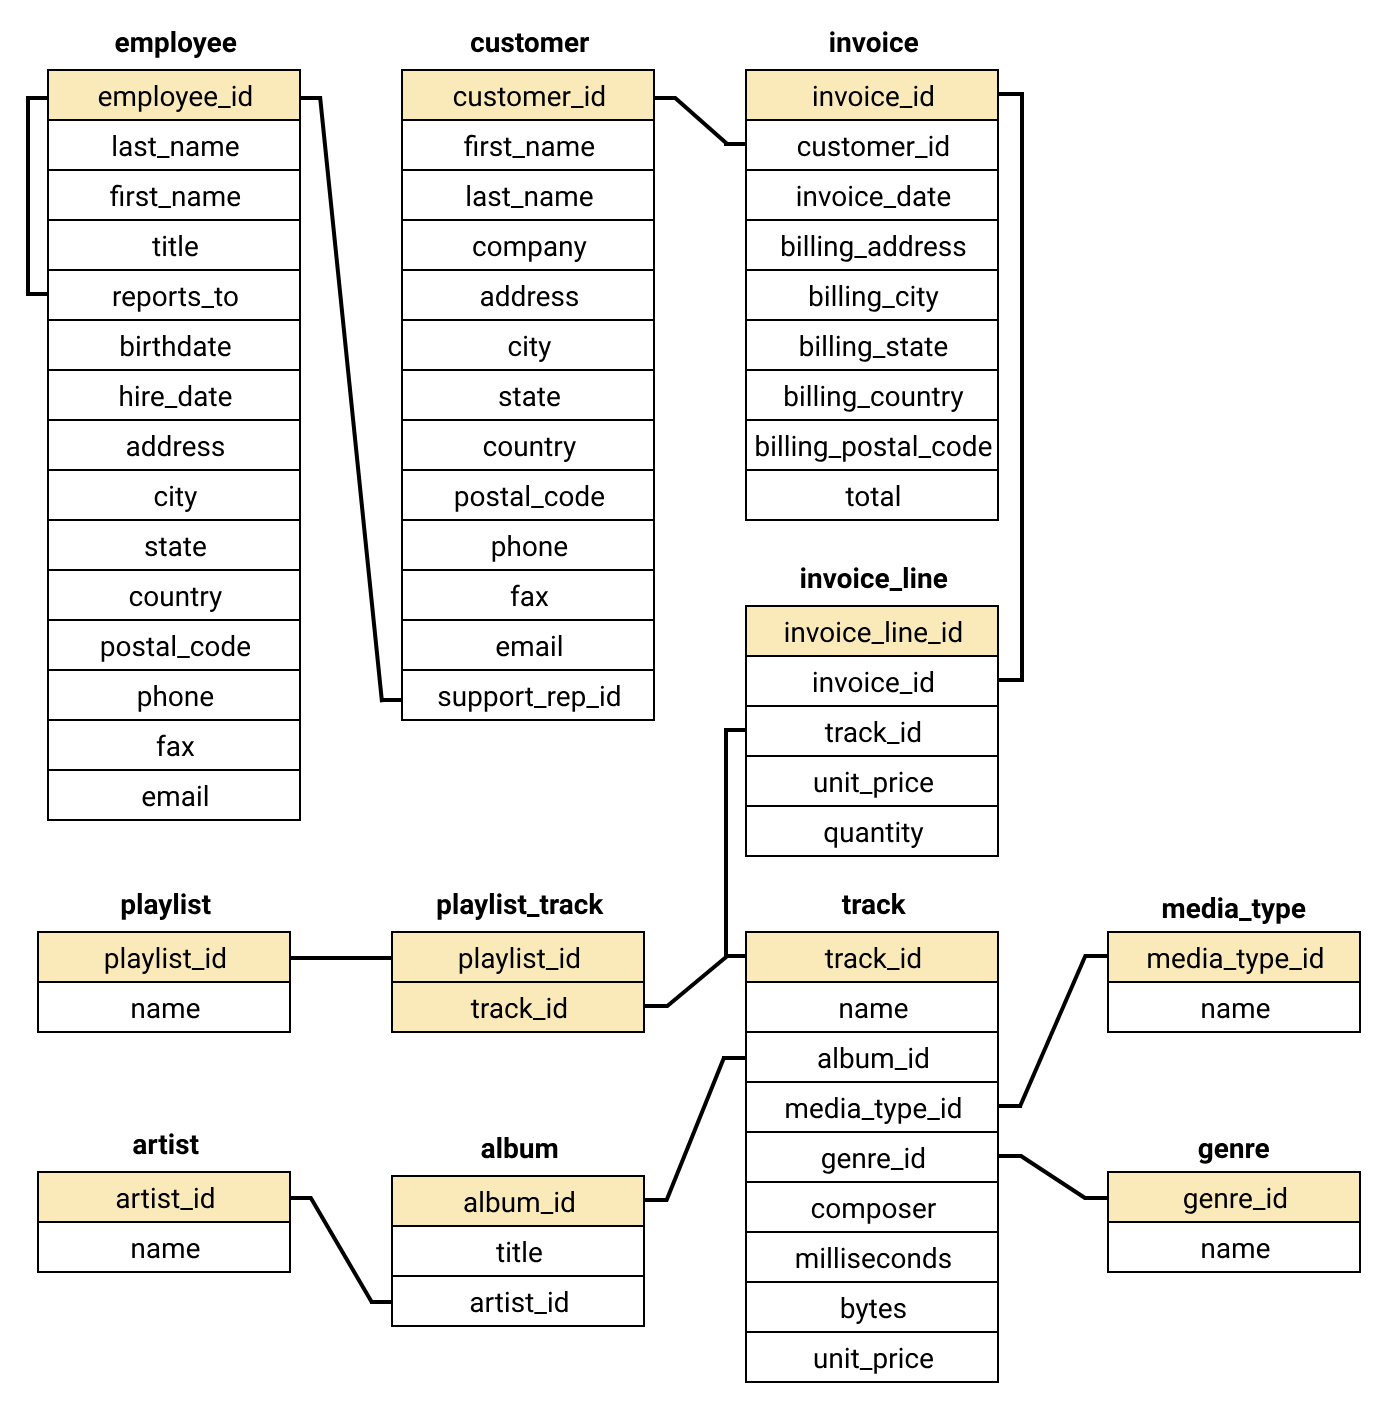

In [1]:
# importing modules
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# creating helper functions

# creating a function that takes a SQL query as an argument and
# returns a pandas dataframe of that query

db = 'chinook.db'

def run_query(query):
    with sqlite3.connect(db) as conn:
        return pd.read_sql_query(query, conn)

In [3]:
# creating a funciton that takes a SQL command as an argument and
# executes it using the sqlite module
def run_command(sql_command):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(sql_command)

In [4]:
# Create a function that calls the run_query() function to return a
# list of all tables and views in the database
def show_tables():
    q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ('table', 'view')
    '''
    return run_query(q)

In [5]:
# running show_tables() function
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [6]:
# examining few rows of the `invoice_line` table

check_q = '''
SELECT * FROM invoice_line
LIMIT 2;
'''
run_query(check_q)

,invoice_line_id,invoice_id,track_id,unit_price,quantity
0,1,1,1158,0.99,1
1,2,1,1159,0.99,1


In [7]:
# determining on new albums to purchase

genre_tracks = '''
WITH 
    usa_tracks_sales AS
    (
     SELECT 
         il.invoice_line_id,
         il.track_id
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     WHERE i.billing_country = 'USA'
    )
SELECT 
    g.name genre,
    COUNT(uts.invoice_line_id) num_tracks_sold,
    CAST(COUNT(uts.invoice_line_id) AS FLOAT) / (
        SELECT COUNT(*) FROM usa_tracks_sales
        ) perct_tracks_sold 
FROM genre g
INNER JOIN track t ON t.genre_id = g.genre_id
INNER JOIN usa_tracks_sales uts ON uts.track_id = t.track_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10;
'''

run_query(genre_tracks)

,genre,num_tracks_sold,perct_tracks_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Pop,22,0.020932
7,Latin,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


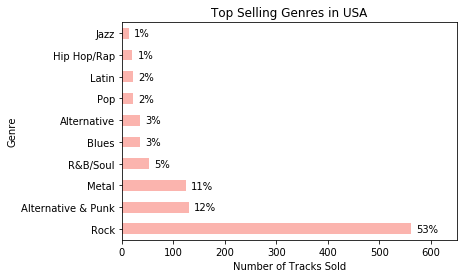

In [8]:
# creating plot for the above results

# saving results in a variable for plotting
genre_sales_usa = run_query(genre_tracks)

# setting index for the table and dropping the column selected as index
genre_sales_usa.set_index('genre', inplace=True, drop=True)

genre_sales_usa.num_tracks_sold.plot.barh(title='Top Selling Genres in USA',
                                          xlim=(0,650), colormap=plt.cm.Pastel1)

plt.xlabel('Number of Tracks Sold')
plt.ylabel('Genre')
# setting the annotation of the bars
for i, label in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[label, 'num_tracks_sold']
    label = (genre_sales_usa.loc[label, 'perct_tracks_sold'] * 100
            ).astype(int).astype(str) + '%'
    plt.annotate(str(label), (score + 10, i - 0.15))
plt.show()

Above results depits that we should purchase the albums from the 'rock' genre, which accounts for 53% of sales. Moreover, albums of below artists should also be considered for purchase:

- Red Tone (Punk)
- Slim Jim Bites (Blues)
- Meteor and the Girls (Pop)

In [9]:
# examining the employee table
employee_table = '''
SELECT * FROM employee
LIMIT 2;
'''
run_query(employee_table)

,employee_id,last_name,first_name,title,reports_to,birthdate,hire_date,address,city,state,country,postal_code,phone,fax,email
0,1,Adams,Andrew,General Manager,NaN,1962-02-18 00:00:00,2016-08-14 00:00:00,11120 Jasper Ave NW,Edmonton,AB,Canada,T5K 2N1,+1 (780) 428-9482,+1 (780) 428-3457,andrew@chinookcorp.com
1,2,Edwards,Nancy,Sales Manager,1.0,1958-12-08 00:00:00,2016-05-01 00:00:00,825 8 Ave SW,Calgary,AB,Canada,T2P 2T3,+1 (403) 262-3443,+1 (403) 262-3322,nancy@chinookcorp.com


In [10]:
# writing a query that finds the total dollar amount of sales assigned to each
# sales support agent within the company

sales_performance_query = '''
SELECT 
    e.first_name || " " || e.last_name employee_name,
    e.hire_date hire_date,
    TOTAL(i.total) total_sales
FROM employee e
INNER JOIN customer c ON c.support_rep_id = e.employee_id
INNER JOIN invoice i ON i.customer_id = c.customer_id
WHERE e.title = 'Sales Support Agent'
GROUP BY 1
ORDER BY 1;
'''
run_query(sales_performance_query)

,employee_name,hire_date,total_sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


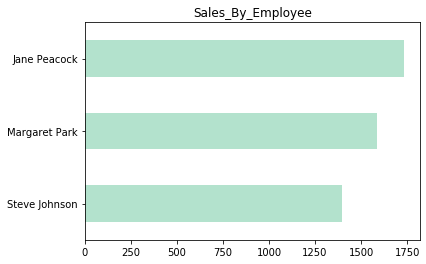

In [11]:
# plotting the above query results
sales_by_employee = run_query(sales_performance_query)

sales_by_employee.set_index('employee_name',
                            inplace=True, drop=True)
sales_by_employee.sort_values('total_sales', inplace=True)

sales_by_employee.plot.barh(title='Sales_By_Employee',
                            legend=False, colormap=plt.cm.Pastel2)
plt.ylabel('')
plt.show()

Above resulting plot depicts that there is a minor difference between the sales by Jane (the top employee based on performance) and Steve (the bottom-one based on performance) as compared to the difference in their hiring dates i.e. of six months.

In [12]:
# analyzing sales by country
sales_by_country = '''
WITH country_or_other AS
    (
     SELECT
         CASE
             WHEN
                 (SELECT COUNT(*)
                  FROM customer
                  WHERE country = c.country
                 ) = 1 THEN 'Other'
             ELSE c.country
         END AS country,
         c.customer_id,
         il.*
     FROM customer c
     INNER JOIN invoice i ON i.customer_id = c.customer_id
     INNER JOIN invoice_line il ON il.invoice_id = i.invoice_id
    )

SELECT 
    country,
    total_num_customers,
    total_sales_value,
    avg_sales_customer,
    avg_order_value
FROM
    (
     SELECT
         country,
         COUNT(DISTINCT (customer_id)) total_num_customers,
         TOTAL(unit_price) total_sales_value,
         TOTAL(unit_price) / COUNT(DISTINCT (customer_id)) avg_sales_customer,
         TOTAL(unit_price) / COUNT(DISTINCT (invoice_id)) avg_order_value,
         CASE
             WHEN country = "Other" THEN 1
             ELSE 0
         END AS sort
     FROM country_or_other
     GROUP BY country
     ORDER BY sort, total_sales_value DESC 
    );
'''
run_query(sales_by_country)

,country,total_num_customers,total_sales_value,avg_sales_customer,avg_order_value
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,Czech Republic,2,273.24,136.620000,9.108000
6,United Kingdom,3,245.52,81.840000,8.768571
7,Portugal,2,185.13,92.565000,6.383793
8,India,2,183.15,91.575000,8.721429
9,Other,15,1094.94,72.996000,7.448571


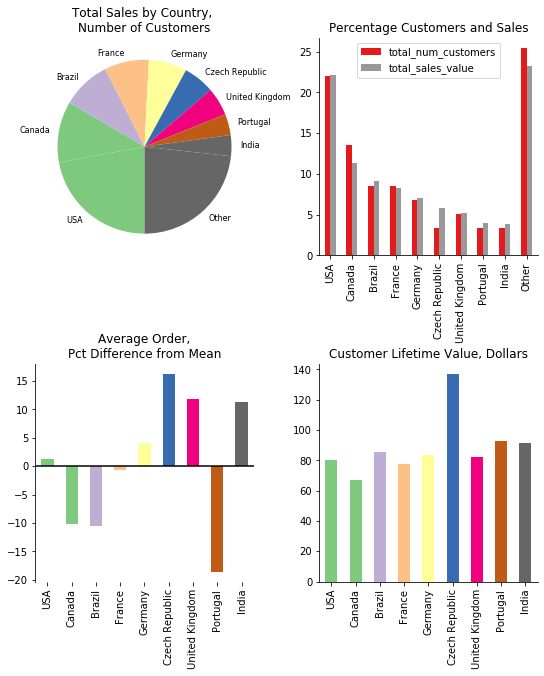

In [24]:
# visualizing sales by country

# assigning the results to variable
country_sales_df = run_query(sales_by_country)
# setting index and dropping column that is selected as index
country_sales_df.set_index('country', inplace=True, drop=True)
# setting colormap of each plot by country
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_sales_df.shape[0])]

# instantiating a figure object and creating subplots/axes
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9,10))
# unpacking the axes/subplots for customized editing/plotting
ax1, ax2, ax3, ax4 = axes.flatten()
# adjusting the height and width of subplots
fig.subplots_adjust(hspace=.5, wspace=.3)

# top left - (1,1)
sales_plot = country_sales_df['total_sales_value'].copy().rename('')
sales_plot.plot.pie(ax=ax1, colormap=plt.cm.Accent,
                    title='Total Sales by Country, \nNumber of Customers', 
                    startangle=-90, counterclock=False, 
                    fontsize=8, wedgeprops={'linewidth':0}
                   )

# top right - (1,2)
cols = ['total_num_customers', 'total_sales_value']
customers_and_sales = country_sales_df[cols].copy()
customers_and_sales.index.name = ''
for c in cols:
    customers_and_sales[c] /= customers_and_sales[c].sum() / 100
customers_and_sales.plot.bar(ax=ax2, colormap=plt.cm.Set1,
                            title='Percentage Customers and Sales'
                           )
ax2.tick_params(top='off', right='off', left='off', bottom='off')
# Hide the right and top spines
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax2.yaxis.set_ticks_position('left')
ax2.xaxis.set_ticks_position('bottom')

# bottom left - (2,1)
avg_order = country_sales_df['avg_order_value'].copy()
avg_order.index.name = ''
mean_diff_from_avg = avg_order * 100 / avg_order.mean() - 100
# dropping 'Other' group as it's not required here
mean_diff_from_avg.drop('Other', inplace=True)
mean_diff_from_avg.plot.bar(ax=ax3, color=colors,
                            title='Average Order,\nPct Difference from Mean'
                           )
ax3.tick_params(top='off', right='off', left='off', bottom='off')
ax3.axhline(0, color='k')

# Hide the right,top and bottom spines
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.spines['bottom'].set_visible(False)

# Only show ticks on the left and bottom spines
ax3.yaxis.set_ticks_position('left')
ax3.xaxis.set_ticks_position('bottom')


# bottom right - (2,2)
avg_customer_sales = country_sales_df['avg_sales_customer'].copy()
avg_customer_sales.index.name = ''
# dropping 'Other' group as it's not required here
avg_customer_sales.drop('Other',inplace=True)
avg_customer_sales.plot.bar(ax=ax4, color=colors, 
                            title='Customer Lifetime Value, Dollars'
                           )
ax4.tick_params(top='off', right='off', left='off', bottom='off')
# Hide the right and top spines
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax4.yaxis.set_ticks_position('left')
ax4.xaxis.set_ticks_position('bottom')

plt.show()

Based on the data, there may be opportunity in the following countries:

- Czech Republic
- United Kingdom
- India

It's worth keeping in mind that because the amount of data from each of these countries is relatively low. Because of this, we should be cautious spending too much money on new marketing campaigns, as the sample size is not large enough to give us high confidence. A better approach would be to run small campaigns in these countries, collecting and analyzing the new customers to make sure that these trends hold with new customers.

In [14]:
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                       ) percent
FROM
    (
    SELECT
        ift.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ift.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ift.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ift.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ift.first_track_id
                                     ) 
                 ) IS NULL
             THEN 'yes'
             ELSE 'no'
         END AS album_purchase
     FROM invoice_first_track ift
    )
GROUP BY 1;
'''

run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


Above results depits that album purchases account for 18.6% of purchases. Based on this data, it is recommended not to purchase selected tracks of albums from record companies, since there is a potential to lose one-fifth (i.e. 18.6%) of revenue.